In [ ]:
# # 실행시 등장하는 URL을 클릭하여 허용해주면 인증KEY가 나타난다. 복사하여 URL아래 빈칸에 붙여넣으면 마운트에 성공하게된다.
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# pip install torch torchvision

In [1]:
import torch

if torch.cuda.is_available():
  device_count = torch.cuda.device_count()
  print("device_count: {}".format(device_count))
  for device_num in range(device_count):
    print("device {} capability {}".format(
        device_num, torch.cuda.get_device_capability(device_num)))
    print("device {} name {}".format(
        device_num, torch.cuda.get_device_name(device_num)))
else:
  print("no cuda device")

no cuda device


In [2]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
from PIL import Image
%matplotlib inline

In [3]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True
print("is_cuda:",is_cuda)

is_cuda: False


In [4]:
#폴더안에 모든 파일 목록을 읽음
path= "C:\dev\Pytorch-workspace_class"   

In [5]:

path= "C:\Workspace\pytorch_class_project"#노트북용 

In [5]:

simple_transform = transforms.Compose([transforms.Resize((224,224)),transforms.Grayscale(),transforms.ToTensor(),transforms.Normalize([0.485], [0.229])])
# simple_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# train = ImageFolder("/content/drive/My Drive/data/emotion/train",simple_transform)

# valid = ImageFolder("C:\dev\Pytorch-workspace_class",simple_transform)


def imshow(inp):

    """Imshow for Tensor."""
    
    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])

    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

   


In [6]:
class Net(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3,stride=1,padding=0)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        self.conv2_drop = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(32*22*22, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        # print("x", x.shape)
        x= F.relu(self.conv1(x))
        # print("x conv1 + relu : ", x.shape)
        x=F.relu(self.conv2(x))
        # print("x conv2 + relu : ", x.shape)
        x=F.max_pool2d(x,2)
        # print("x max pool(2) : ", x.shape)
        x = F.dropout(x,p=0.25, training=self.training)
        # print("x dropout : ", x.shape)
        x=x.view(-1,32*22*22)
        x=F.relu(self.fc1(x))
        x = F.dropout(x,p=0.5, training=self.training)
        x=self.fc2(x)

        # print("x view : ", x.shape)
        return F.log_softmax(x,dim=1)


In [7]:
##TJ_mk2용 net
#메모리 부족으로인한 배치사이즈 4변경 에폭 15 기준 적합, 이후 과적합 단 학습률 보장을위해 20회까지 돌림
class Net(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1,padding=0)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3,stride=1,padding=0)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3,stride=1,padding=1)
        self.conv7 = nn.Conv2d(64, 32, kernel_size=3,stride=1,padding=0)


        self.fc1 = nn.Linear(32*2*2, 256)
        
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)


    def forward(self, x):
        # print("x", x.shape)
        x= F.relu(self.conv1(x))
        # print("x conv1 + relu : ", x.shape)
        x=F.relu(self.conv2(x))
        # print("x conv2 + relu : ", x.shape)
        x=F.max_pool2d(x,2)
        # print("x max pool(2) : ", x.shape)
        x=F.relu(self.conv3(x))
        
        # print("x conv3 : ", x.shape)
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv4(x))
        
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv5(x))
        
        x=F.max_pool2d(x,2,padding=1)
        
        x=F.relu(self.conv6(x))
        x=F.max_pool2d(x,2,padding=1)

        # print("x max pool(5) : ", x.shape)
        x=F.relu(self.conv7(x))
        x=F.max_pool2d(x,2,padding=0)
        
        # print("x max pool(5) : ", x.shape)

        x = F.dropout(x,p=0.25, training=self.training)
        # print("x dropout : ", x.shape)
        x=x.view(-1,32*2*2)
        x=F.relu(self.fc1(x))
        x = F.dropout(x,p=0.5, training=self.training)
        x=F.relu(self.fc2(x))
        x=self.fc3(x)

        return F.log_softmax(x,dim=1)

      

In [9]:
##TJ_mk3,4용 net
#메모리 부족으로인한 배치사이즈 4변경 에폭 15 기준 적합, 이후 과적합 단 학습률 보장을위해 20회까지 돌림
class Net(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3,stride=1,padding=0)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3,stride=1,padding=0)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3,stride=1,padding=1)
        self.conv7 = nn.Conv2d(64, 32, kernel_size=3,stride=1,padding=0)


        self.fc1 = nn.Linear(32*2*2, 256)
        
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)


    def forward(self, x):
        # print("x", x.shape)
        x= F.relu(self.conv1(x))
        # print("x conv1 + relu : ", x.shape)
        x=F.relu(self.conv2(x))
        # print("x conv2 + relu : ", x.shape)
        x=F.max_pool2d(x,2)
        # print("x max pool(2) : ", x.shape)
        x=F.relu(self.conv3(x))
        
        # print("x conv3 : ", x.shape)
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv4(x))
        
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv5(x))
        
        x=F.max_pool2d(x,2,padding=1)
        
        x=F.relu(self.conv6(x))
        x=F.max_pool2d(x,2,padding=1)

        # print("x max pool(5) : ", x.shape)
        x=F.relu(self.conv7(x))
        x=F.max_pool2d(x,2,padding=0)
        
        # print("x max pool(5) : ", x.shape)

        x = F.dropout(x,p=0.25, training=self.training)
        # print("x dropout : ", x.shape)
        x=x.view(-1,32*2*2)
        x=F.relu(self.fc1(x))
        x = F.dropout(x,p=0.5, training=self.training)
        x=F.relu(self.fc2(x))
        x=self.fc3(x)

        return F.log_softmax(x,dim=1)

      

In [8]:
##TJ_mk6용 net
#메모리 부족으로인한 배치사이즈 4변경 에폭 15 기준 적합, 이후 과적합 단 학습률 보장을위해 20회까지 돌림, 드롭아웃 재설정
class Net(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3,stride=1,padding=0)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3,stride=1,padding=0)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3,stride=1,padding=1)
        self.conv7 = nn.Conv2d(64, 32, kernel_size=3,stride=1,padding=0)


        self.fc1 = nn.Linear(32*2*2, 256)
        
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)


    def forward(self, x):
        # print("x", x.shape)
        x= F.relu(self.conv1(x))
        # print("x conv1 + relu : ", x.shape)
        x=F.relu(self.conv2(x))
        # print("x conv2 + relu : ", x.shape)
        x=F.max_pool2d(x,2)
        # print("x max pool(2) : ", x.shape)
        x=F.relu(self.conv3(x))
        
        # print("x conv3 : ", x.shape)
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv4(x))
        
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv5(x))
        
        x=F.max_pool2d(x,2,padding=1)
        
        x=F.relu(self.conv6(x))
        x=F.max_pool2d(x,2,padding=1)

        # print("x max pool(5) : ", x.shape)
        x=F.relu(self.conv7(x))
        x=F.max_pool2d(x,2,padding=0)
        
        # print("x max pool(5) : ", x.shape)

        # print("x dropout : ", x.shape)
        x=x.view(-1,32*2*2)
        x=F.relu(self.fc1(x))
        x = F.dropout(x,p=0.5, training=self.training)
        x=F.relu(self.fc2(x))
        x = F.dropout(x,p=0.5, training=self.training)
        x=self.fc3(x)

        return F.log_softmax(x,dim=1)

      

In [9]:
device=torch.device('cpu')
# model = torch.load(path+'\TJ_hoon.pt',map_location=device)
model=Net()
model.load_state_dict(torch.load(path+'\TJ_hoon_mk3.pt',map_location=device))
model.eval()

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
)

In [10]:
valid = ImageFolder("C:\Workspace\pytorch_class_project",simple_transform)#노트북용

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\Workspace\\pytorch_class_project'

In [38]:
valid = ImageFolder("C:\dev\Pytorch-workspace_class",simple_transform)

In [39]:
# data=ImageFolder("C:\dev\Pytorch-workspace_class\images", simple_transform)



validloader=DataLoader(valid)
dataiter=iter(validloader)
images,labels=dataiter.next()
print(labels)


tensor([3])


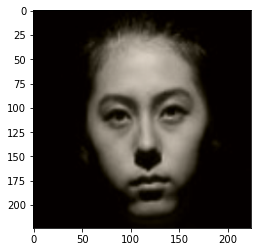

In [57]:
imshow(make_grid(images))

In [58]:
res=['angry','disgust','fear','happy','neutral','sad','surprise']

In [59]:
(model(images).argmax(1))
res[(model(images).argmax(1))]

'neutral'

In [109]:
toList = torch.exp(model(images)).tolist()

In [110]:
print(toList)

[[0.09621187299489975, 0.000414855225244537, 0.038303375244140625, 0.0162758007645607, 0.735499918460846, 0.1072968989610672, 0.005997276399284601]]


In [112]:
toRoundedList=[[i*100 for i in nest]for nest in toList]
toRoundedList = [[round(num,1) for num in nest]for nest in toRoundedList]
print(toRoundedList)

[[9.6, 0.0, 3.8, 1.6, 73.5, 10.7, 0.6]]


이부분부터 리턴해줘야됨

In [78]:
a_list = [1.234, 2.345, 3.45, 1.45]
round_to_tenths = [round(num, 1) for num in a_list]

print(round_to_tenths)

[1.2, 2.3, 3.5, 1.4]
